In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import gensim.downloader as api
from datetime import datetime

# Style configuration for "good looking" plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported and style configured.")

✅ Libraries imported and style configured.


In [2]:
LOAD_WORD2VEC = True

def load_model(model_name):
    """Safe loader with timestamp logging."""
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ⏳ Downloading/Loading {model_name}...")
    try:
        model = api.load(model_name)
        print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ {model_name} loaded successfully!")
        return model
    except Exception as e:
        print(f"❌ Failed to load {model_name}: {e}")
        return None

# Load GloVe
glove = load_model("glove-wiki-gigaword-100")

# Load Word2Vec
w2v = load_model("word2vec-google-news-300") if LOAD_WORD2VEC else None

# Create a dictionary for easy access
models = {"GloVe (Wiki-100)": glove}
if w2v: models["Word2Vec (GoogleNews)"] = w2v

[10:58:26] ⏳ Downloading/Loading glove-wiki-gigaword-100...
[10:59:03] ✅ glove-wiki-gigaword-100 loaded successfully!
[10:59:03] ⏳ Downloading/Loading word2vec-google-news-300...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
[11:02:42] ✅ word2vec-google-news-300 loaded successfully!


In [3]:
def compare_analogy(model_name, model, p1, n1, p2):
    """
    Solves: p1 - n1 + p2 = ?
    Example: King - Man + Woman = ?
    """
    if not model: return
    
    try:
        result = model.most_similar(positive=[p1, p2], negative=[n1], topn=1)
        print(f"   🔹 {model_name}: {p1} - {n1} + {p2} = **{result[0][0]}** (Confidence: {result[0][1]:.2f})")
    except KeyError as e:
        print(f"   ⚠️ Word not found in vocabulary: {e}")

def visualize_embeddings(models, word_groups):
    """
    Plots words in 2D space using PCA.
    Accepts a dictionary of models to compare.
    """
    # Flatten word list
    all_words = [w for group in word_groups.values() for w in group]
    
    # Create subplots based on number of models
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(10 * n_models, 8))
    if n_models == 1: axes = [axes] # Handle single model case

    for ax, (name, model) in zip(axes, models.items()):
        if not model: continue
        
        # 1. Get Vectors
        vectors = []
        valid_words = []
        for word in all_words:
            if word in model:
                vectors.append(model[word])
                valid_words.append(word)
        
        if not vectors:
            print(f"No valid words found for {name}")
            continue

        # 2. Reduce Dimensions (PCA)
        pca = PCA(n_components=2)
        coords = pca.fit_transform(vectors)
        x = coords[:, 0]
        y = coords[:, 1]
        
        # 3. Plot
        group_colors = sns.color_palette("husl", len(word_groups))
        
        for i, (group_name, words) in enumerate(word_groups.items()):
            # Find indices of words in this group
            indices = [valid_words.index(w) for w in words if w in valid_words]
            if not indices: continue
            
            group_x = x[indices]
            group_y = y[indices]
            
            # Scatter points
            ax.scatter(group_x, group_y, label=group_name, s=200, color=group_colors[i], alpha=0.8, edgecolors='white', linewidth=2)
            
            # Annotate text
            for j, word_idx in enumerate(indices):
                ax.text(x[word_idx]+0.02, y[word_idx]+0.02, valid_words[word_idx], fontsize=11, fontweight='bold')

        ax.set_title(f"{name} Embedding Space (PCA)", fontsize=16, fontweight='bold')
        ax.legend(loc='upper right', frameon=True)
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

print("✅ Functions defined.")

✅ Functions defined.


In [4]:
print("\n--- 🧠 ANALOGY CHALLENGE ---")

comparisons = [
    ('king', 'man', 'woman'),       # The Classic
    ('paris', 'france', 'germany'), # Geography
    ('sushi', 'japan', 'italy'),    # Food Culture
    ('walk', 'walking', 'swim')     # Grammar
]

for p1, n1, p2 in comparisons:
    print(f"\nEquation: '{p1}' - '{n1}' + '{p2}'")
    for name, model in models.items():
        compare_analogy(name, model, p1, n1, p2)

print("\n--- 🔍 SIMILARITY CHECK ---")
target_word = "computer"
print(f"Words most similar to '{target_word}':")
for name, model in models.items():
    if model:
        top_3 = [w[0] for w in model.most_similar(target_word, topn=3)]
        print(f"   🔹 {name}: {top_3}")


--- 🧠 ANALOGY CHALLENGE ---

Equation: 'king' - 'man' + 'woman'
   🔹 GloVe (Wiki-100): king - man + woman = **queen** (Confidence: 0.77)
   🔹 Word2Vec (GoogleNews): king - man + woman = **queen** (Confidence: 0.71)

Equation: 'paris' - 'france' + 'germany'
   🔹 GloVe (Wiki-100): paris - france + germany = **berlin** (Confidence: 0.88)
   🔹 Word2Vec (GoogleNews): paris - france + germany = **berlin** (Confidence: 0.48)

Equation: 'sushi' - 'japan' + 'italy'
   🔹 GloVe (Wiki-100): sushi - japan + italy = **tapas** (Confidence: 0.62)
   🔹 Word2Vec (GoogleNews): sushi - japan + italy = **gourmet_pizza** (Confidence: 0.58)

Equation: 'walk' - 'walking' + 'swim'
   🔹 GloVe (Wiki-100): walk - walking + swim = **swam** (Confidence: 0.54)
   🔹 Word2Vec (GoogleNews): walk - walking + swim = **swims** (Confidence: 0.63)

--- 🔍 SIMILARITY CHECK ---
Words most similar to 'computer':
   🔹 GloVe (Wiki-100): ['computers', 'software', 'technology']
   🔹 Word2Vec (GoogleNews): ['computers', 'laptop', '


--- 🎨 GENERATING VISUALIZATION ---


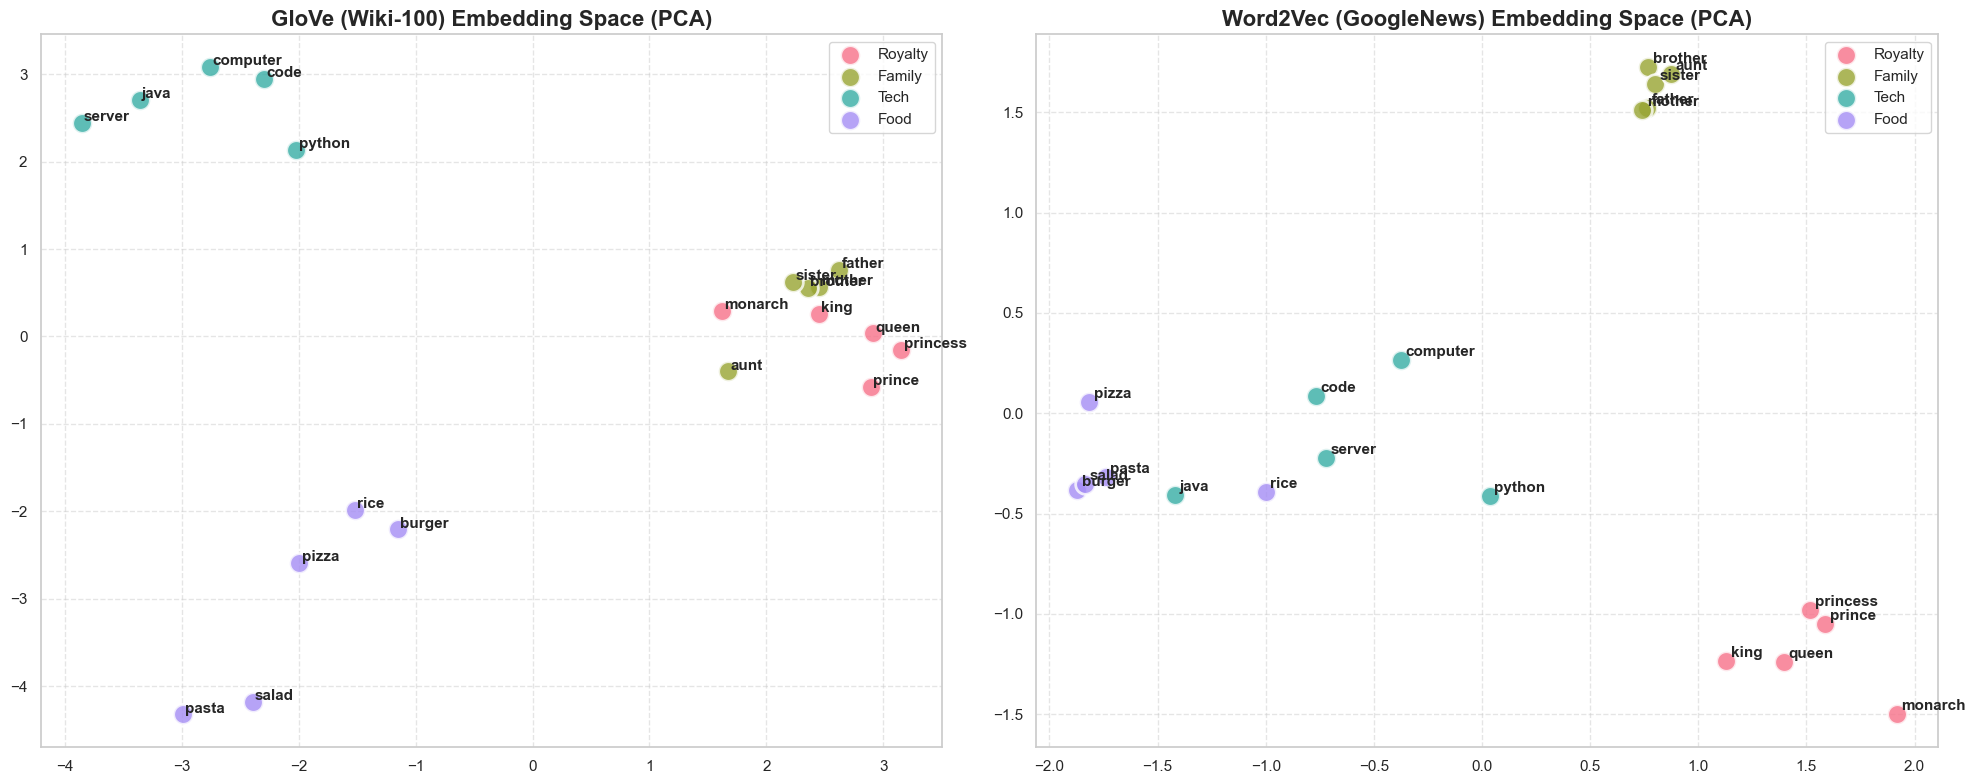

In [5]:
print("\n--- 🎨 GENERATING VISUALIZATION ---")

# Define semantic clusters to visualize
# Feel free to change these words!
word_groups = {
    "Royalty": ["king", "queen", "prince", "princess", "monarch"],
    "Family": ["father", "mother", "brother", "sister", "aunt"],
    "Tech": ["computer", "code", "python", "java", "server"],
    "Food": ["pizza", "burger", "pasta", "salad", "rice"]
}

visualize_embeddings(models, word_groups)